In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch
import numpy as np
import pandas as pd

train = pd.read_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/train_tweets.csv",low_memory=False)
test = pd.read_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/test_tweets.csv",low_memory=False)

train.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,retweet_count,text,encoded_labels
0,569264328186179584,negative,1.0,Cancelled Flight,0.6715,0,@SouthwestAir reservation (FEHQNE) 21FEB15 |...,2
1,569628431236911104,negative,1.0,Can't Tell,0.6567,0,@AmericanAir rented van drove 250 miles with 6...,2
2,567758699574226944,positive,1.0,NaN,NaN,0,@JetBlue @JayVig @roxydigital awww ^_^ R to th...,1
3,567789435795861504,negative,1.0,Customer Service Issue,1.0000,0,@united customer service 👎,2
4,569584207011434497,negative,1.0,Bad Flight,0.6442,0,@USAirways why have me board a plane knowing t...,2


In [ ]:
# train.to_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/train_tweets.csv",index=False)
# test.to_csv("/content/drive/MyDrive/Projects/Temperature Scaling of NN/test_tweets.csv",index=False)

In [ ]:
print("Here's a neutral tweet: ", train[train['airline_sentiment']=='neutral'].sample(1)['text'].values.item())
print("Here's a positive tweet: ", train[train['airline_sentiment']=='positive'].sample(1)['text'].values.item())
print("Here's a negetive tweet: ", train[train['airline_sentiment']=='negative'].sample(1)['text'].values.item())

Here's a neutral tweet:  @united Want to make my day? :) Friend is Premier &amp; I should be soon. Any chance you can upgrade our two 10 hr leg of flights to ecom plus?
Here's a positive tweet:  @AmericanAir versus @JetBlue 
in Customer Service?
Who will win!
For Me @AmericanAir is a convenience to a trip to Cali &lt;3
Here's a negetive tweet:  @united I just checked my united app and the most valuable use of this app has been removed. I can no longer see the status of my equipment?


In [ ]:
!pip install -U -q sentence-transformers
!pip install -q transformers
!pip install -q nltk
!pip install -q torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.1/227.1 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 37.6 MB/s eta 0:00:00


In [ ]:
import re
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from transformers import AutoModel, AutoTokenizer
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt


"""
    text pre processing pipeline. keeping it minimal since we want to leverage models
    vocabulary. We will vectorize the input text using BERT and then train a classifier
    on top of it. Before vectorizing, removing stopwords, punctuations are necessary to
    span the latent space properly.
"""
class PreProcess:
    def __init__(self,
                 model_id:str="prajjwal1/bert-small"):
        self.model_id = model_id
        self.model = SentenceTransformer(self.model_id)
        self.lemmatizer = WordNetLemmatizer()
        self.tokenizer = word_tokenize


    def clean_text(self,text:str)->str:
        """
            Remove special characters, phone numbers,punctuation marks, links, and emails.
            Tokenize & Lemmatize the text
        """
        text = re.sub(r'https?://\S+|www\.\S+|<.*?>|[^A-Za-z0-9]+', ' ', text)
        text = re.sub(r'\b\d{10}\b|\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b', ' ', text)
        tokens = self.tokenizer(text)
        lemmatized_tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Join the lemmatized tokens into a string
        cleaned_text = ' '.join(lemmatized_tokens)

        return cleaned_text

    def vectorize(self,text:str)->torch.Tensor:
        """
            Vectorizer function using the sentence transformer
            model.
        """
        return self.model.encode(text)

    def transform(self,text:str)->torch.Tensor:
        """
            The transform method, cleans the input
            text and then vectorizes it using a sentence
            transformer model.
        """
        return self.vectorize(
            self.clean_text(text)
        )


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
_process = PreProcess()

config.json:   0%|          | 0.00/286 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/116M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
print("Text Before cleaning: ",train['text'][8])
print("#####################################")
print("Text after cleaning: ",
      _process.clean_text(train['text'][8]))

Text Before cleaning:  @SouthwestAir @HDsportsguy yes I did. I hope for an update soon, need those clothes for a meeting tomorrow.
#####################################
Text after cleaning:  SouthwestAir HDsportsguy yes I did I hope for an update soon need those clothes for a meeting tomorrow


In [ ]:
sample_text_embedding = _process.transform(train['text'][8])
print(
    f"A sentence embedding of type {type(sample_text_embedding)} and shape {sample_text_embedding.shape} generated using BERT small model."
)

A sentence embedding of type <class 'numpy.ndarray'> and shape (512,) generated using BERT small model.


**Define a classifier head and try to train it with a custom defined parameter that'll callibrate the probablities of the output logits.**

We'll start with having two intermediate layers and one dense layer with one scaling layer to provide the final callibrated softmax probablities.

In [ ]:
import torch
from torch.utils.data import Dataset

class TweetsDataset(Dataset):
    def __init__(self, annotations_file):
        self.transformer = PreProcess()
        self.data = annotations_file

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx, transform=False):
        label = self.data.loc[idx, 'encoded_labels']
        if transform:
            text_vector = self.transformer.transform(self.data.loc[idx,'text'])
            return text_vector, label
        return self.transformer.clean_text(self.data.loc[idx,'text']), label

In [ ]:
from torch.utils.data import DataLoader as dataloader
train_dataloader = dataloader(TweetsDataset(train.reset_index(drop=True)),batch_size=16)
test_dataloader = dataloader(TweetsDataset(test.reset_index(drop=True)),batch_size=8)

In [ ]:
def compute_acc_bin(conf_thresh_lower, conf_thresh_upper, conf, pred, true):
    """
    # Computes accuracy and average confidence for bin

    Args:
        conf_thresh_lower (float): Lower Threshold of confidence interval
        conf_thresh_upper (float): Upper Threshold of confidence interval
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels

    Returns:
        (accuracy, avg_conf, len_bin): accuracy of bin, confidence of bin and number of elements in bin.
    """
    filtered_tuples = [x for x in zip(pred, true, conf) if x[2] > conf_thresh_lower and x[2] <= conf_thresh_upper]
    if len(filtered_tuples) < 1:
        return 0,0,0
    else:
        correct = len([x for x in filtered_tuples if x[0] == x[1]])  # How many correct labels
        len_bin = len(filtered_tuples)  # How many elements falls into given bin
        avg_conf = sum([x[2] for x in filtered_tuples]) / len_bin  # Avg confidence of BIN
        accuracy = float(correct)/len_bin  # accuracy of BIN
        return accuracy, avg_conf, len_bin


def ECE(conf, pred, true, bin_size = 0.1):
    """
    Expected Calibration Error

    Args:
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        bin_size: (float): size of one bin (0,1)  # TODO should convert to number of bins?

    Returns:
        ece: expected calibration error
    """

    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)  # Get bounds of bins

    n = len(conf)
    ece = 0  # Starting error

    for conf_thresh in upper_bounds:  # Go through bounds and find accuracies and confidences
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, conf, pred, true)
        ece += np.abs(acc-avg_conf)*len_bin/n  # Add weigthed difference to ECE

    return ece


def get_bin_info(conf, pred, true, bin_size = 0.1):
    """
    Get accuracy, confidence and elements in bin information for all the bins.

    Args:
        conf (numpy.ndarray): list of confidences
        pred (numpy.ndarray): list of predictions
        true (numpy.ndarray): list of true labels
        bin_size: (float): size of one bin (0,1)  # TODO should convert to number of bins?

    Returns:
        (acc, conf, len_bins): tuple containing all the necessary info for reliability diagrams.
    """

    upper_bounds = np.arange(bin_size, 1+bin_size, bin_size)

    accuracies = []
    confidences = []
    bin_lengths = []

    for conf_thresh in upper_bounds:
        acc, avg_conf, len_bin = compute_acc_bin(conf_thresh-bin_size, conf_thresh, conf, pred, true)
        accuracies.append(acc)
        confidences.append(avg_conf)
        bin_lengths.append(len_bin)


    return accuracies, confidences, bin_lengths

# reliability diagram plotting for subplot case.
def rel_diagram_sub(accs, confs, M = 10, name = "Reliability Diagram", xname = "Confidence", yname="Accuracy",save_name=""):
    acc_conf = np.column_stack([accs,confs])
    acc_conf.sort(axis=1)
    outputs = acc_conf[:, 0]
    gap = acc_conf[:, 1]

    bin_size = 1/M
    positions = np.arange(0+bin_size/2, 1+bin_size/2, bin_size)

    # Plot gap first, so its below everything
    gap_plt = plt.bar(positions, gap, width = bin_size, edgecolor = "red", color = "red", alpha = 0.3, label="Gap", linewidth=2, zorder=2)

    # Next add error lines
    #for i in range(M):
        #plt.plot([i/M,1], [0, (M-i)/M], color = "red", alpha=0.5, zorder=1)

    #Bars with outputs
    output_plt = plt.bar(positions, outputs, width = bin_size, edgecolor = "black", color = "blue", label="Outputs", zorder = 3)

    # Line plot with center line.
    plt.gca().set_aspect('equal')
    plt.plot([0,1], [0,1], linestyle = "--")
    plt.legend(handles = [gap_plt, output_plt])
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.title(f"{save_name.split('.')[0]}", fontsize=24)
    plt.xlabel(xname, fontsize=22, color = "black")
    plt.ylabel(yname, fontsize=22, color = "black")
    plt.savefig(f'/content/drive/MyDrive/Projects/Temperature Scaling of NN/{save_name}', dpi=300)
    plt.show()

### Train the Model with Scaling

In [ ]:
class SentimentClassifier(torch.nn.Module):

    def __init__(self,num_labels:int):
        """
            A ANN impletention with dynamic
            probablity callibration during
            training
        """
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("prajjwal1/bert-small")
        self.init_scaling_factor = torch.ones(num_labels)
        self.scaling_factor = torch.nn.Parameter(self.init_scaling_factor, requires_grad=True)
        self.linear1 = torch.nn.Linear(self.bert.config.hidden_size, 64)
        self.dropout = torch.nn.Dropout(p=0.1,inplace=False)
        self.norm1 = torch.nn.BatchNorm1d(64)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(64, 16)
        self.norm2 = torch.nn.BatchNorm1d(16)
        self.dense = torch.nn.Linear(16,num_labels)


    def forward(self,input):
        """
            The forward pass
        """
        x = self.bert(**input)[0][:,0,:]  # Get the [CLS] token output
        x = self.activation(self.norm1(self.dropout(self.linear1(x))))
        x = self.norm2(self.linear2(x))
        x  = self.dense(x)/self.scaling_factor
        return x

In [ ]:
import torch.nn as nn
import torch.optim as optim

loss = nn.CrossEntropyLoss()
tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-small")
model = SentimentClassifier(num_labels=train['airline_sentiment'].nunique())
optimizer = optim.Adam(model.parameters())

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"""
    Placing the model to the GPU/TPU (if available) else CPU
"""
model.to(device)

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-3): 4 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, element

In [ ]:
model.scaling_factor.detach().cpu().numpy()

array([1., 1., 1.], dtype=float32)

In [ ]:
%%time
from tqdm import tqdm

num_epochs = 15
training_loss, callib_error_train,\
 validation_loss, callib_error_test  = [], [], [], []
# track calibration metrics
conf, prediction, true = list(), list(), list()
"""
    The training loop
"""
for epoch in range(num_epochs):
    model.train()
    epoch_loss, epoch_callibration_error = 0, 0
    for idx, batch in tqdm(enumerate(train_dataloader),desc=f"Epoch {epoch}"):
        input = batch[0]
        tokenized_input = tokenizer(input,truncation=True, padding=True, max_length=model.bert.config.max_length,return_tensors="pt").to(device)
        labels = batch[1].to(device)
        """
            Training Step
        """
        # zero the parameter gradients
        optimizer.zero_grad()
        output = model(tokenized_input)
        # Back Propogation Step
        loss_val = loss(output,labels)
        epoch_loss += loss_val.data
        # Calculate the callibration error
        training_batch_callibration_error = ECE(conf=output.softmax(dim=1).max(dim=1).values.detach().cpu().numpy(),
                                    pred=output.argmax(dim=1),true=labels)
        epoch_callibration_error +=  training_batch_callibration_error
        loss_val.backward()
        # Gradient Descent
        optimizer.step()
        # Clamp the temp value towards >1 direction (As suggested by Guo et al.)
        # classmethod for torch.nn.Parameter(1 + torch.sigmoid(model.scaling_factor) * (2 - 1),  requires_grad=True)
        model.scaling_factor.data.clamp_(min=0,max=float('Inf'))
        # break

    training_loss.append(epoch_loss)
    callib_error_train.append(epoch_callibration_error)
    print("Epoch: {}, Training loss: {}, Training Error: {}".format(epoch+1,epoch_loss,epoch_callibration_error))

    """
        Evaluation step
    """
    eval_loss, eval_error = 0, 0
    # detach the parameter gradients
    model.eval()
    with torch.no_grad():
        for eval_idx, eval_batch in tqdm(enumerate(test_dataloader),desc='Eval Step'):
            eval_input = eval_batch[0]
            eval_input = tokenizer(eval_input,truncation=True, padding=True, max_length=model.bert.config.max_length,return_tensors="pt").to(device)
            eval_labels = eval_batch[1].to(device)
            eval_output = model(eval_input)
            conf.append(
                eval_output.softmax(dim=1).max(dim=1).values.detach().cpu().numpy()
                )
            prediction.append(eval_output.argmax(dim=1).detach().cpu().numpy())
            true.append(eval_labels.detach().cpu().numpy())
            # Get the loss value for the current batch
            loss_val = loss(eval_output,eval_labels)
            eval_loss += loss_val.data
            #Get the callibration error for the current batch
            batch_callibration_error = ECE(conf=eval_output.softmax(dim=1).max(dim=1).values.detach().cpu().numpy(),
                                    pred=eval_output.argmax(dim=1),true=eval_labels)
            eval_error +=  batch_callibration_error
    validation_loss.append(eval_loss)
    callib_error_test.append(eval_error)
    print("Epoch: {}, Eval loss: {}, Eval Error: {}".format(epoch+1,eval_loss,eval_error))
    # break
print(
    f"Training for {num_epochs} epochs done!!"
)

Epoch 0: 732it [00:22, 32.45it/s]


Epoch: 1, Training loss: 633.5908813476562, Training Error: 154.7606203313917


Eval Step: 366it [00:06, 53.72it/s]


Epoch: 1, Eval loss: 300.8765869140625, Eval Error: 90.15693752840161


Epoch 1: 732it [00:19, 37.44it/s]


Epoch: 2, Training loss: 664.7691040039062, Training Error: 131.56596647016704


Eval Step: 366it [00:04, 90.58it/s]


Epoch: 2, Eval loss: 339.8197937011719, Eval Error: 52.660570815205574


Epoch 2: 732it [00:19, 38.26it/s]


Epoch: 3, Training loss: 673.4440307617188, Training Error: 114.43281810358167


Eval Step: 366it [00:03, 99.97it/s] 


Epoch: 3, Eval loss: 337.90484619140625, Eval Error: 51.18616126477718


Epoch 3: 732it [00:19, 36.80it/s]


Epoch: 4, Training loss: 672.5694580078125, Training Error: 105.90283227153122


Eval Step: 366it [00:02, 122.25it/s]


Epoch: 4, Eval loss: 337.77947998046875, Eval Error: 50.24102149158716


Epoch 4: 732it [00:18, 39.06it/s]


Epoch: 5, Training loss: 671.29248046875, Training Error: 104.98950159363449


Eval Step: 366it [00:03, 99.23it/s]


Epoch: 5, Eval loss: 338.457763671875, Eval Error: 51.524663120508194


Epoch 5: 732it [00:18, 38.84it/s]


Epoch: 6, Training loss: 671.2490844726562, Training Error: 106.74412102252245


Eval Step: 366it [00:03, 114.55it/s]


Epoch: 6, Eval loss: 337.5751037597656, Eval Error: 49.91192511469126


Epoch 6: 732it [00:18, 40.09it/s]


Epoch: 7, Training loss: 671.3178100585938, Training Error: 98.9322167225182


Eval Step: 366it [00:04, 85.69it/s] 


Epoch: 7, Eval loss: 337.5422668457031, Eval Error: 49.277191907167435


Epoch 7: 732it [00:18, 40.41it/s]


Epoch: 8, Training loss: 670.4309692382812, Training Error: 102.63251086696982


Eval Step: 366it [00:03, 117.79it/s]


Epoch: 8, Eval loss: 337.6050720214844, Eval Error: 49.00537001341581


Epoch 8: 732it [00:21, 33.91it/s]


Epoch: 9, Training loss: 670.570556640625, Training Error: 96.56024774722755


Eval Step: 366it [00:03, 117.44it/s]


Epoch: 9, Eval loss: 337.6475830078125, Eval Error: 49.825590535998344


Epoch 9: 732it [00:17, 40.74it/s]


Epoch: 10, Training loss: 668.612548828125, Training Error: 101.25821986794472


Eval Step: 366it [00:03, 94.76it/s]


Epoch: 10, Eval loss: 337.5888366699219, Eval Error: 50.25683993846178


Epoch 10: 732it [00:18, 39.33it/s]


Epoch: 11, Training loss: 668.879150390625, Training Error: 100.94692325033247


Eval Step: 366it [00:03, 114.81it/s]


Epoch: 11, Eval loss: 339.9726257324219, Eval Error: 56.01009410619736


Epoch 11: 732it [00:18, 39.90it/s]


Epoch: 12, Training loss: 668.9533081054688, Training Error: 100.5355674456805


Eval Step: 366it [00:04, 89.99it/s] 


Epoch: 12, Eval loss: 350.0989990234375, Eval Error: 63.8882764428854


Epoch 12: 732it [00:18, 40.13it/s]


Epoch: 13, Training loss: 667.21875, Training Error: 104.54832839779556


Eval Step: 366it [00:03, 114.31it/s]


Epoch: 13, Eval loss: 344.7967834472656, Eval Error: 60.40086977183819


Epoch 13: 732it [00:20, 36.01it/s]


Epoch: 14, Training loss: 668.0272827148438, Training Error: 108.3940218705684


Eval Step: 366it [00:03, 114.75it/s]


Epoch: 14, Eval loss: 350.12493896484375, Eval Error: 65.36214714124799


Epoch 14: 732it [00:19, 38.09it/s]


Epoch: 15, Training loss: 667.9185180664062, Training Error: 106.19376424141228


Eval Step: 366it [00:04, 80.09it/s]

Epoch: 15, Eval loss: 349.7776794433594, Eval Error: 62.57469216734171
Training for 15 epochs done!!
CPU times: user 5min 38s, sys: 6.19 s, total: 5min 44s
Wall time: 5min 46s


In [ ]:
model.scaling_factor.detach().cpu().numpy()

array([1.0502284, 0.9820467, 1.1139702], dtype=float32)

In [ ]:
print("Norm of temp vecotr: ",np.linalg.norm(
    model.scaling_factor.detach().cpu().numpy()
))

Norm of temp vecotr:  1.8188801


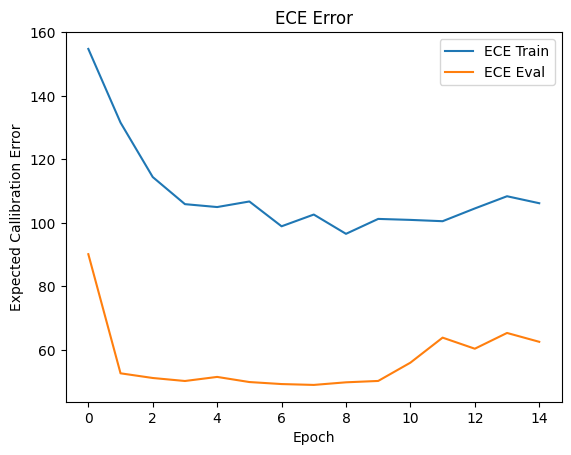

In [ ]:
plt.plot(callib_error_train,label="ECE Train")
plt.plot(callib_error_test,label="ECE Eval")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Expected Callibration Error')
plt.title('ECE Error')
plt.savefig(f'/content/drive/MyDrive/Projects/Temperature Scaling of NN/BertSmallTrainedClassifierScaledError_Plot.jpeg', dpi=300)
plt.show()

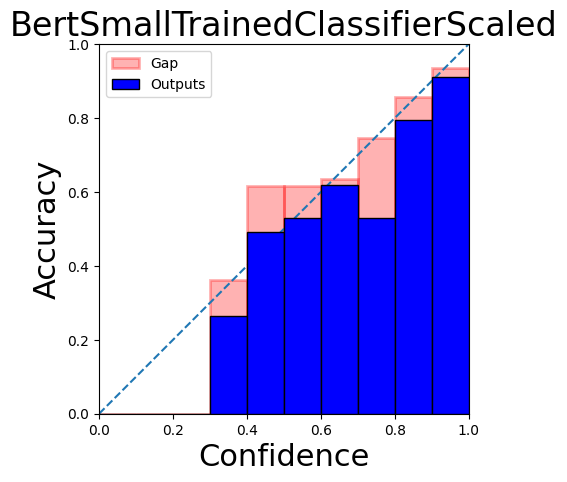

In [ ]:
conf = [j for i in conf for j in i]
prediction = [j for i in prediction for j in i]
true = [j for i in true for j in i]
_acc, _confs, _ = get_bin_info(conf,prediction,true)

# get the reliabilty diagram
rel_diagram_sub(_acc,_confs,save_name="BertSmallTrainedClassifierScaled.jpeg")

In [ ]:
pd.DataFrame({
    'conf':conf,
    'prediction':prediction,
    'true':true
}).to_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/BertSmallTrainedClassifierScaled.csv')

In [ ]:
metrics_df = pd.merge(
    pd.DataFrame({
    'Loss':[_loss_.detach().cpu().numpy().item() for _loss_ in training_loss],
    'ECE':callib_error_train
}).reset_index(drop=False).rename(columns={'index':'Epoch'}),
    pd.DataFrame({
    'Loss':[_loss_.detach().cpu().numpy().item() for _loss_ in validation_loss],
    'ECE':callib_error_test
}),
    right_index=True,left_index=True,suffixes=("_train","_eval")
)

metrics_df

,Epoch,Loss_train,ECE_train,Loss_eval,ECE_eval
0,0,633.590881,154.760620,300.876587,90.156938
1,1,664.769104,131.565966,339.819794,52.660571
2,2,673.444031,114.432818,337.904846,51.186161
3,3,672.569458,105.902832,337.779480,50.241021
4,4,671.292480,104.989502,338.457764,51.524663
5,5,671.249084,106.744121,337.575104,49.911925
6,6,671.317810,98.932217,337.542267,49.277192
7,7,670.430969,102.632511,337.605072,49.005370
8,8,670.570557,96.560248,337.647583,49.825591
9,9,668.612549,101.258220,337.588837,50.256840


In [ ]:
path = '/content/drive/MyDrive/Projects/Temperature Scaling of NN/checkpoint_BertSmallTrainedClassifierScaled.pt'

pd.DataFrame({
    'conf':conf,'pred':prediction,'true':true
}).to_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/BertSmallTrainedClassifierScaledRelDiagData.csv',index=False)
metrics_df.to_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/BertSmallTrainedClassifierScaledMetrics.csv',index=False)
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, path)

### Train the UnScaled Model

In [ ]:
class SentimentClassifierBase(torch.nn.Module):

    def __init__(self,num_labels:int):
        """
            A ANN impletention with dynamic
            probablity callibration during
            training
        """
        super(SentimentClassifierBase, self).__init__()
        self.bert = AutoModel.from_pretrained("prajjwal1/bert-small")
        self.linear1 = torch.nn.Linear(self.bert.config.hidden_size, 64)
        self.dropout = torch.nn.Dropout(p=0.1,inplace=False)
        self.norm1 = torch.nn.BatchNorm1d(64)
        self.activation = torch.nn.ReLU()
        self.linear2 = torch.nn.Linear(64, 16)
        self.norm2 = torch.nn.BatchNorm1d(16)
        self.dense = torch.nn.Linear(16,num_labels)

    def forward(self,input):
        """
            The forward pass
        """
        x = self.bert(**input)[0][:,0,:]  # Get the [CLS] token output
        x = self.activation(self.norm1(self.dropout(self.linear1(x))))
        x = self.norm2(self.linear2(x))
        # x  = self.dense(x)/self.scaling_factor
        return self.dense(x)

model_base = SentimentClassifierBase(num_labels=train['airline_sentiment'].nunique())
optimizer_base = optim.Adam(model_base.parameters())

In [ ]:
%%time
from tqdm import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
"""
    Placing the model to the GPU/TPU (if available) else CPU
"""
model_base.to(device)
num_epochs = 15
training_loss, callib_error_train,\
 validation_loss, callib_error_test  = [], [], [], []
# track calibration metrics
conf, prediction, true = list(), list(), list()
"""
    The training loop
"""
for epoch in range(num_epochs):
    model_base.train()
    epoch_loss, epoch_callibration_error = 0, 0
    for idx, batch in tqdm(enumerate(train_dataloader),desc=f"Epoch {epoch}"):
        input = batch[0]
        tokenized_input = tokenizer(input,truncation=True, padding=True, max_length=model.bert.config.max_length,return_tensors="pt").to(device)
        labels = batch[1].to(device)

        """
            Training Step
        """
        # zero the parameter gradients
        optimizer_base.zero_grad()
        output = model_base(tokenized_input)
        # Back Propogation Step
        loss_val = loss(output,labels)
        epoch_loss += loss_val.data
        # Calculate the callibration error
        training_batch_callibration_error = ECE(conf=output.softmax(dim=1).max(dim=1).values.detach().cpu().numpy(),
                                    pred=output.argmax(dim=1),true=labels)
        epoch_callibration_error +=  training_batch_callibration_error
        loss_val.backward()
        # Gradient Descent
        optimizer_base.step()
        # break

    training_loss.append(epoch_loss)
    callib_error_train.append(epoch_callibration_error)
    print("Epoch: {}, Training loss: {}, Training Error: {}".format(epoch+1,epoch_loss,epoch_callibration_error))

    """
        Evaluation step
    """
    eval_loss, eval_error = 0, 0
    # detach the parameter gradients
    model_base.eval()
    with torch.no_grad():
        for eval_idx, eval_batch in tqdm(enumerate(test_dataloader),desc='Eval Step'):
            eval_input = eval_batch[0]
            eval_input = tokenizer(eval_input,truncation=True, padding=True, max_length=model.bert.config.max_length,return_tensors="pt").to(device)
            eval_labels = eval_batch[1].to(device)
            eval_output = model_base(eval_input)
            conf.append(
                eval_output.softmax(dim=1).max(dim=1).values.detach().cpu().numpy()
                )
            prediction.append(eval_output.argmax(dim=1).detach().cpu().numpy())
            true.append(eval_labels.detach().cpu().numpy())
            # Get the loss value for the current batch
            loss_val = loss(eval_output,eval_labels)
            eval_loss += loss_val.data
            #Get the callibration error for the current batch
            batch_callibration_error = ECE(conf=eval_output.softmax(dim=1).max(dim=1).values.detach().cpu().numpy(),
                                    pred=eval_output.argmax(dim=1),true=eval_labels)
            eval_error +=  batch_callibration_error
    validation_loss.append(eval_loss)
    callib_error_test.append(eval_error)
    print("Epoch: {}, Eval loss: {}, Eval Error: {}".format(epoch+1,eval_loss,eval_error))
    # break

print(
    f"Training for {num_epochs} epochs done!!"
)

Epoch 0: 732it [00:29, 25.19it/s]


Epoch: 1, Training loss: 667.4734497070312, Training Error: 149.3665617350489


Eval Step: 366it [00:04, 74.25it/s] 


Epoch: 1, Eval loss: 339.80645751953125, Eval Error: 54.87882620096207


Epoch 1: 732it [00:26, 27.49it/s]


Epoch: 2, Training loss: 675.8771362304688, Training Error: 121.29767139814794


Eval Step: 366it [00:04, 74.70it/s]


Epoch: 2, Eval loss: 337.257080078125, Eval Error: 49.008310839533806


Epoch 2: 732it [00:32, 22.72it/s]


Epoch: 3, Training loss: 674.0783081054688, Training Error: 112.70811018161476


Eval Step: 366it [00:03, 98.57it/s] 


Epoch: 3, Eval loss: 338.2261657714844, Eval Error: 51.71085833013058


Epoch 3: 732it [00:38, 19.22it/s]


Epoch: 4, Training loss: 672.04931640625, Training Error: 111.25593034178019


Eval Step: 366it [00:05, 70.06it/s]


Epoch: 4, Eval loss: 337.3789978027344, Eval Error: 49.528650395572186


Epoch 4: 732it [00:18, 39.28it/s]


Epoch: 5, Training loss: 671.9153442382812, Training Error: 107.58376021496952


Eval Step: 366it [00:03, 118.00it/s]


Epoch: 5, Eval loss: 337.9661560058594, Eval Error: 51.02860730141401


Epoch 5: 732it [00:18, 40.24it/s]


Epoch: 6, Training loss: 672.0001220703125, Training Error: 99.15624075196683


Eval Step: 366it [00:04, 84.12it/s] 


Epoch: 6, Eval loss: 337.4566345214844, Eval Error: 49.99497368186712


Epoch 6: 732it [00:31, 23.13it/s]


Epoch: 7, Training loss: 670.45068359375, Training Error: 101.26240656897426


Eval Step: 366it [00:05, 72.58it/s]


Epoch: 7, Eval loss: 340.27337646484375, Eval Error: 53.81667286902666


Epoch 7: 732it [00:22, 32.77it/s]


Epoch: 8, Training loss: 671.3187866210938, Training Error: 101.46521562710404


Eval Step: 366it [00:05, 69.05it/s]


Epoch: 8, Eval loss: 337.5140075683594, Eval Error: 49.809205405414104


Epoch 8: 732it [00:21, 33.56it/s]


Epoch: 9, Training loss: 671.3242797851562, Training Error: 97.0893132276833


Eval Step: 366it [00:03, 120.12it/s]


Epoch: 9, Eval loss: 337.5221862792969, Eval Error: 50.03615526854992


Epoch 9: 732it [00:17, 40.99it/s]


Epoch: 10, Training loss: 670.48583984375, Training Error: 96.42272878065705


Eval Step: 366it [00:03, 108.29it/s]


Epoch: 10, Eval loss: 338.08465576171875, Eval Error: 51.31024735420942


Epoch 10: 732it [00:18, 38.62it/s]


Epoch: 11, Training loss: 670.5833129882812, Training Error: 96.47740549966693


Eval Step: 366it [00:03, 119.00it/s]


Epoch: 11, Eval loss: 337.70172119140625, Eval Error: 49.38295738399029


Epoch 11: 732it [00:17, 40.80it/s]


Epoch: 12, Training loss: 670.2570190429688, Training Error: 94.3640793710947


Eval Step: 366it [00:04, 90.52it/s]


Epoch: 12, Eval loss: 337.5650329589844, Eval Error: 50.44590724259615


Epoch 12: 732it [00:18, 39.97it/s]


Epoch: 13, Training loss: 670.5680541992188, Training Error: 95.66520579531789


Eval Step: 366it [00:03, 113.00it/s]


Epoch: 13, Eval loss: 337.6357116699219, Eval Error: 49.36743348836899


Epoch 13: 732it [00:18, 39.23it/s]


Epoch: 14, Training loss: 670.1865844726562, Training Error: 94.72189505025744


Eval Step: 366it [00:05, 72.35it/s]


Epoch: 14, Eval loss: 337.9743957519531, Eval Error: 51.11225386708975


Epoch 14: 732it [00:18, 40.14it/s]


Epoch: 15, Training loss: 670.5027465820312, Training Error: 91.64303161203861


Eval Step: 366it [00:03, 116.51it/s]

Epoch: 15, Eval loss: 337.4828186035156, Eval Error: 50.135547302663326
Training for 15 epochs done!!
CPU times: user 5min 59s, sys: 6.22 s, total: 6min 6s
Wall time: 6min 50s


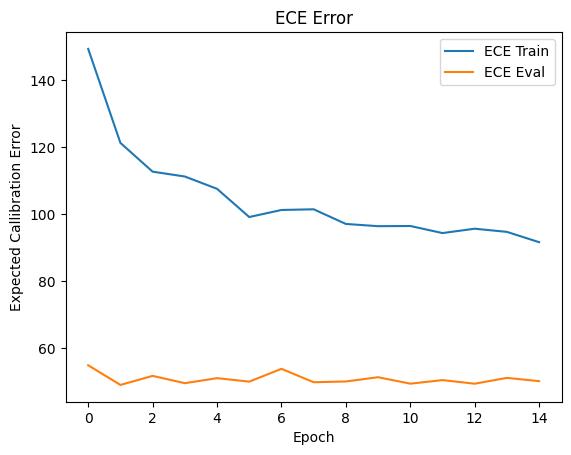

In [ ]:
plt.plot(callib_error_train,label="ECE Train")
plt.plot(callib_error_test,label="ECE Eval")
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Expected Callibration Error')
plt.title('ECE Error')
plt.savefig(f'/content/drive/MyDrive/Projects/Temperature Scaling of NN/BertSmallTrainedClassifierUnScaledError_Plot.jpeg', dpi=300)
plt.show()

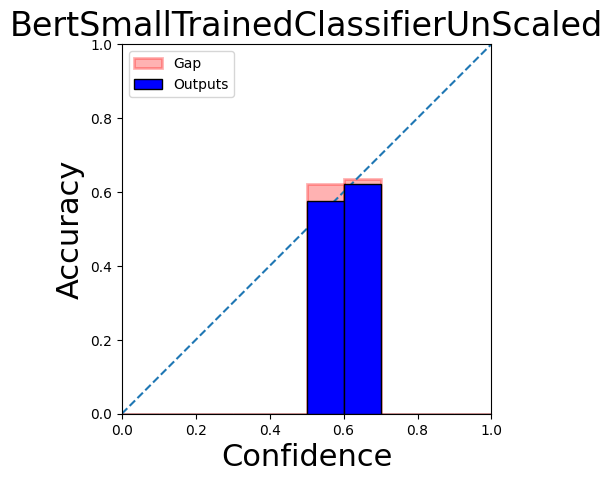

In [ ]:
conf = [j for i in conf for j in i]
prediction = [j for i in prediction for j in i]
true = [j for i in true for j in i]
_acc, _confs, _ = get_bin_info(conf,prediction,true)

# get the reliabilty diagram
rel_diagram_sub(_acc,_confs,save_name="BertSmallTrainedClassifierUnScaled.jpeg")

In [ ]:
pd.DataFrame({
    'conf':conf,
    'prediction':prediction,
    'true':true
}).to_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/BertSmallTrainedClassifierUnScaled.csv')

In [ ]:
"""
    we try to scale the logits with random temperature
    values ranging from 0 to 1 with a step size of .10 as a grid
    search method to see if the values provided during training
    are the most optimal ones or not.
"""

response = []
temp_values = np.arange(1,2,.1)
for temp in tqdm(temp_values):
    """
        Evaluation step
    """
    eval_loss, eval_error = 0, 0
    # detach the parameter gradients
    model_base.eval()
    with torch.no_grad():
        for eval_idx, eval_batch in enumerate(test_dataloader):
            eval_input = eval_batch[0]
            eval_input = tokenizer(eval_input,truncation=True, padding=True, max_length=model.bert.config.max_length,return_tensors="pt").to(device)
            eval_labels = eval_batch[1].to(device)
            eval_output = model_base(eval_input)
            eval_output = eval_output/temp
            # Get the loss value for the current batch
            loss_val = loss(eval_output,eval_labels)
            eval_loss += loss_val.data
            #Get the callibration error for the current batch
            batch_callibration_error = ECE(conf=eval_output.softmax(dim=1).max(dim=1).values.detach().cpu().numpy(),
                                    pred=eval_output.argmax(dim=1),true=eval_labels)
            eval_error +=  batch_callibration_error
    response.append({
        'Temp Value':temp,
        'Loss':eval_loss,
        'ECE':eval_error
    })
    # break

100%|██████████| 10/10 [00:38<00:00,  3.84s/it]


In [ ]:
response = pd.DataFrame(response)
response

,Temp Value,Loss,ECE
0,0.0,"tensor(nan, device='cuda:0')",0.000000
1,0.1,"tensor(1723.2390, device='cuda:0')",138.994525
2,0.2,"tensor(863.3138, device='cuda:0')",137.352092
3,0.3,"tensor(586.3871, device='cuda:0')",127.540118
4,0.4,"tensor(462.5476, device='cuda:0')",109.428916
5,0.5,"tensor(400.9716, device='cuda:0')",89.773590
6,0.6,"tensor(368.9428, device='cuda:0')",74.360862
7,0.7,"tensor(352.0443, device='cuda:0')",60.886723
8,0.8,"tensor(343.2895, device='cuda:0')",56.689691
9,0.9,"tensor(339.0831, device='cuda:0')",53.137852


In [ ]:
metrics_df = pd.merge(
    pd.DataFrame({
    'Loss':[_loss_.detach().cpu().numpy().item() for _loss_ in training_loss],
    'ECE':callib_error_train
}).reset_index(drop=False).rename(columns={'index':'Epoch'}),
    pd.DataFrame({
    'Loss':[_loss_.detach().cpu().numpy().item() for _loss_ in validation_loss],
    'ECE':callib_error_test
}),
    right_index=True,left_index=True,suffixes=("_train","_eval")
)

metrics_df

,Epoch,Loss_train,ECE_train,Loss_eval,ECE_eval
0,0,667.473450,149.366562,339.806458,54.878826
1,1,675.877136,121.297671,337.257080,49.008311
2,2,674.078308,112.708110,338.226166,51.710858
3,3,672.049316,111.255930,337.378998,49.528650
4,4,671.915344,107.583760,337.966156,51.028607
5,5,672.000122,99.156241,337.456635,49.994974
6,6,670.450684,101.262407,340.273376,53.816673
7,7,671.318787,101.465216,337.514008,49.809205
8,8,671.324280,97.089313,337.522186,50.036155
9,9,670.485840,96.422729,338.084656,51.310247


In [ ]:
metrics_df.to_csv('/content/drive/MyDrive/Projects/Temperature Scaling of NN/BertSmallTrainedClassifierUnScaledMetrics.csv',index=False)